In [1]:
from datetime import date

from util.dataset import FeaturePassengerFlowDataset

# noinspection PyProtectedMember
data = FeaturePassengerFlowDataset(
    min_date=date(2022, 1, 1),
    max_date=date(2023, 7, 1)
)._data

data['time'] = data.index.to_series().apply(lambda idx: f'{idx[0].hour:02d}:{idx[0].minute:02d}')
data['weekday'] = data.index.to_series().apply(lambda idx: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][idx[0].weekday()])

data

LOADING DATA: 100%|██████████| 14/14 [03:30<00:00, 15.00s/it]


passengers     noise  weekend   
datetime            origin destination                                  
2022-01-01 00:00:00 12     19                159.0  0.304939     True  \
                           LM                  6.0 -1.456441     True   
                           OW                 25.0 -1.558501     True   
                    16     24                 78.0  0.451318     True   
                           CC                 82.0  0.865496     True   
...                                            ...       ...      ...   
2023-06-30 23:00:00 WD     ED                110.0 -1.519143    False   
                    WP     NC                 10.0  0.890731    False   
                           PC                 53.0  0.916043    False   
                    WS     FM                 34.0  0.878724    False   
                           ML                 91.0  0.328786    False   

                                        hours_00_04  hours_04_08  hours_08_12   
datetime            origin destination                                          
2022-01-01 00:00:00 12     19                  True        False        False  \
                           LM                  True        False        False   
                           OW                  True        False        False   
                    16     24                  True        False        False   
                           CC                  True        False        False   
...                                             ...          ...          ...   
2023-06-30 23:00:00 WD     ED                 False        False        False   
                    WP     NC                 False        False        False   
                           PC                 False        False        False   
                    WS     FM                 False        False        False   
                           ML                 False        False        False   

                                        hours_12_16  hours_16_20  hours_20_24   
datetime            origin destination                                          
2022-01-01 00:00:00 12     19                 False        False        False  \
                           LM                 False        False        False   
                           OW                 False        False        False   
                    16     24                 False        False        False   
                           CC                 False        False        False   
...                                             ...          ...          ...   
2023-06-30 23:00:00 WD     ED                 False        False         True   
                    WP     NC                 False        False         True   
                           PC                 False        False         True   
                    WS     FM                 False        False         True   
                           ML                 False        False         True   

                                        event_capacity  ...   
datetime            origin destination                  ...   
2022-01-01 00:00:00 12     19                      0.0  ...  \
                           LM                      0.0  ...   
                           OW                      0.0  ...   
                    16     24                      0.0  ...   
                           CC                      0.0  ...   
...                                                ...  ...   
2023-06-30 23:00:00 WD     ED                      0.0  ...   
                    WP     NC                      0.0  ...   
                           PC                      0.0  ...   
                    WS     FM                      0.0  ...   
                           ML                      0.0  ...   

                                        event_type_festival event_type_lgbtq   
datetime            origin destination                                         
20

### Regularity of flow

In [74]:
import pandas as pd
from parallel_pandas import ParallelPandas
from tqdm.notebook import tqdm

tqdm.pandas()
ParallelPandas.initialize()

def remove_trend(df: pd.DataFrame) -> pd.Series:
    from statsmodels.tsa.stl._stl import STL

    stl_fit = STL(df.passengers,
                  period=3,
                  low_pass=5,
                  robust=True).fit()

    return stl_fit.trend

# Detect trend
normalized = data.assign(trend=data
                         .groupby(['origin', 'destination', 'weekday', 'time'])
                         .p_apply(remove_trend)
                         .droplevel([0, 1, 2, 3]))
normalized['normalized'] = normalized.passengers - normalized.trend
normalized['mean'] = normalized.groupby(['origin', 'destination', 'weekday', 'time']).apply(lambda df: df.normalized.mean() + df.trend).droplevel([0, 1, 2, 3])
normalized['lower'] = normalized.groupby(['origin', 'destination', 'weekday', 'time']).apply(lambda df: df.normalized.quantile(0.10) + df.trend).droplevel([0, 1, 2, 3])
normalized['upper'] = normalized.groupby(['origin', 'destination', 'weekday', 'time']).apply(lambda df: df.normalized.quantile(0.90) + df.trend).droplevel([0, 1, 2, 3])

normalized = normalized[['mean', 'lower', 'upper']]

normalized

REMOVE_TREND DONE:   0%|          | 0/17136 [00:00<?, ?it/s]

mean      lower       upper
datetime            origin destination                                   
2022-01-01 00:00:00 12     19           150.237769  22.011172  278.745071
                           LM            26.755525   5.500901   49.890638
                           OW            57.749715   8.759476  132.351973
                    16     24            44.516290 -19.917108  131.146463
                           CC            95.415129  67.231212  128.688774
...                                            ...        ...         ...
2023-06-30 23:00:00 WD     ED           125.755604  90.775952  172.747879
                    WP     NC            13.950183   9.941646   19.380242
                           PC            42.070807  27.247870   58.695092
                    WS     FM            31.055462  22.842618   38.381706
                           ML            71.776997  53.442871   94.615959

[1336608 rows x 3 columns]

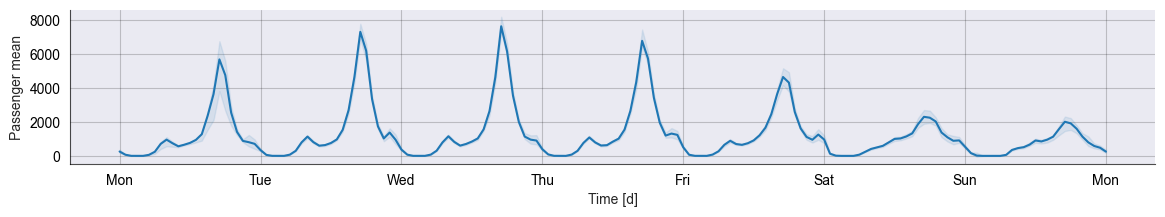

In [75]:
from matplotlib.dates import DateFormatter
from util.plotstyle import style_plot
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

regularity_example = normalized.loc[:, 'EM', 'OW'].loc[datetime(2022, 7, 4):datetime(2022, 7, 11)]

fig, axes = plt.subplots(1, 1, figsize=(14, 2))

axes.fill_between(
    regularity_example.index.to_series(),
    regularity_example['upper'],
    regularity_example['lower'],
    color='tab:blue',
    alpha=0.1
)
sns.lineplot(regularity_example['mean'])

axes.set_xlabel('Time [d]')
axes.set_ylabel('Passenger mean')
style_plot(axes)

axes.xaxis.set_major_formatter(DateFormatter("%a"))

plt.savefig('figures/flow-regularity-EM-OW.png', dpi=300, bbox_inches='tight', transparent=True)

### SARIMA Order Selection

In [58]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(data.loc[:, 'EM', 'OW'].passengers,
                maxlag=168+4,
                regression='c')
print('Regular:', 'Stationary' if test[1] <= 0.05 else 'Non-stationary', f'({test[1]:.4f})')

test = adfuller(data.loc[:, 'EM', 'OW'].passengers.iloc[::24],
                regression='c')
print('Seasonal (24):', 'Stationary' if test[1] <= 0.05 else 'Non-stationary', f'({test[1]:.4f})')

Regular: Non-stationary (0.1226)
Seasonal (24): Stationary (0.0232)


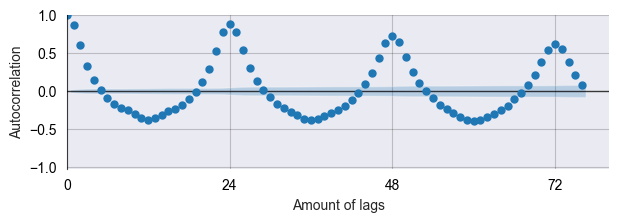

In [59]:
from matplotlib.ticker import MultipleLocator
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(7, 2))
axes.axhline(y=0,
             alpha=0.7,
             color='black',
             linewidth=1)

plot_acf(data.loc[:, 'EM', 'OW'].passengers,
         lags=72+4,
         title=None,
         use_vlines=False,
         ax=axes)

style_plot(axes)
axes.spines['bottom'].set_visible(False)

axes.xaxis.set_major_locator(MultipleLocator(24))

axes.set_xlim(0, 80)
axes.set_ylim(-1.02, 1)

axes.set_xlabel('Amount of lags')
axes.set_ylabel('Autocorrelation')

plt.savefig('figures/autocorrelation.png', dpi=300, bbox_inches='tight', transparent=True)

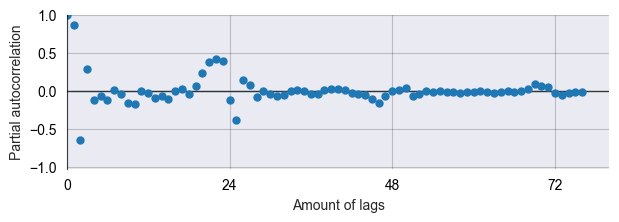

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1, 1, figsize=(7, 2))
axes.axhline(y=0,
             alpha=0.7,
             color='black',
             linewidth=1)

plot_pacf(data.loc[:, 'EM', 'OW'].passengers,
          lags=72+4,
          method="ols",
          title=None,
          use_vlines=False,
          ax=axes)

style_plot(axes)
axes.spines['bottom'].set_visible(False)

axes.xaxis.set_major_locator(MultipleLocator(24))

axes.set_xlim(0, 80)
axes.set_ylim(-1.02, 1)

axes.set_xlabel('Amount of lags')
axes.set_ylabel('Partial autocorrelation')

plt.savefig('figures/autocorrelation-partial.png', dpi=300, bbox_inches='tight', transparent=True)

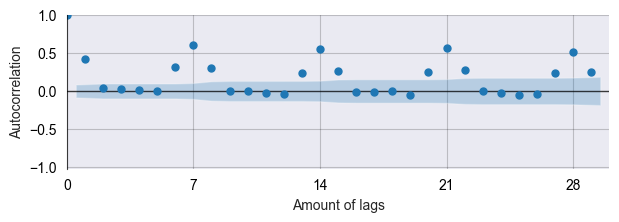

In [61]:
fig, axes = plt.subplots(1, 1, figsize=(7, 2))
axes.axhline(y=0,
             alpha=0.7,
             color='black',
             linewidth=1)

plot_acf(data.loc[:, 'EM', 'OW'].passengers.iloc[::24],
         lags=29,
         title=None,
         use_vlines=False,
         ax=axes)

style_plot(axes)
axes.spines['bottom'].set_visible(False)

axes.xaxis.set_major_locator(MultipleLocator(7))

axes.set_xlim(0, 30)
axes.set_ylim(-1.02, 1)

axes.set_xlabel('Amount of lags')
axes.set_ylabel('Autocorrelation')

plt.savefig('figures/seasonal-autocorrelation.png', dpi=300, bbox_inches='tight', transparent=True)

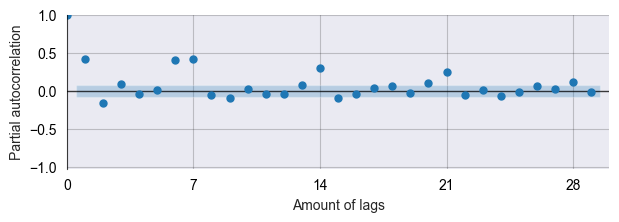

In [62]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1, 1, figsize=(7, 2))
axes.axhline(y=0,
             alpha=0.7,
             color='black',
             linewidth=1)

plot_pacf(data.loc[:, 'EM', 'OW'].passengers.iloc[::24],
          lags=29,
          method="ols",
          title=None,
          use_vlines=False,
          ax=axes)

style_plot(axes)
axes.spines['bottom'].set_visible(False)

axes.xaxis.set_major_locator(MultipleLocator(7))

axes.set_xlim(0, 30)
axes.set_ylim(-1.02, 1)

axes.set_xlabel('Amount of lags')
axes.set_ylabel('Partial autocorrelation')

plt.savefig('figures/seasonal-autocorrelation-partial.png', dpi=300, bbox_inches='tight', transparent=True)